In [1]:
import matplotlib.pyplot as plt

import configs as cf
from preprocess import *
from network import *
from train_tts import *
from text_to_speech import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set Dataset
full_ds = get_single_speaker_dataset(
    cf.SPEAKER, cf.WAV_PATH, cf.SCRIPT_FILE_NAME,
    cf.SR, cf.N_MELS, cf.N_FFT, cf.HOP_LENGTH, cf.WIN_LENGTH
)

full_dl = get_dl_by_ds(full_ds, cf.BATCH_SIZE, cf.DL_NUM_WORKERS, shuffle=True)

Loading ['여1_소설1', '여1_자기계발2', '여1_동화1', '여1_자기계발1'] ...
소설1 Done!
자기계발2 Done!
동화1 Done!
자기계발1 Done!


In [4]:
MODEL_FILE_PATH = './model/single_speaker_tts_best.pt'

model = torch.load(MODEL_FILE_PATH).to(device)

In [5]:
# model = Transformer(
#     len(cf.ALL_SYMBOLS), cf.N_MELS, cf.N_LAYERS, cf.HIDDEN_DIM,
#     cf.N_HEADS, cf.PF_DIM, cf.TEXT_SEQ_LEN, cf.SPEECH_SEQ_LEN,
#     cf.PAD_IDX, cf.DROPOUT_RATIO, device
# ).to(device)
# model.eval()

In [6]:
batch = iter(full_dl).next()
tensor_dict_to_device(batch, device)

In [7]:
mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

query: torch.Size([8, 8, 88, 32])
tensor([[-18.6307,  49.6742,  18.8351,  ...,  15.4049,  21.7049, -23.6810],
        [  1.6895,  59.3016,  25.7369,  ...,  48.1640,  -9.9665,  -3.3203],
        [ 16.0520,  59.5326,  -7.4750,  ...,  14.9248,  33.5742, -30.7699],
        ...,
        [-32.5825, -16.1543,   4.4542,  ..., -32.4417, -27.3060,  16.9892],
        [-17.0007, -13.7145,  14.5181,  ..., -23.3579, -17.1981,   3.9816],
        [-10.1004, -16.1128,  20.6751,  ..., -18.8053, -16.3342,  -0.6260]],
       device='cuda:0', grad_fn=<SelectBackward0>)

key: torch.Size([8, 8, 88, 32])
tensor([[ 18.3410,  -2.4830, -19.3847,  ..., -50.0297, -34.4450,  10.6485],
        [  6.6613,  -5.6093, -24.8251,  ...,  -2.8989, -43.3387, -29.4680],
        [ 11.1720,   7.6848, -45.0772,  ..., -25.0535, -36.3471,  -5.6465],
        ...,
        [-15.3124,  15.3590, -23.4538,  ...,  -7.1836,  -0.3642,  24.5382],
        [-15.8176,  13.3694, -24.0934,  ..., -10.8845,  -9.1181,  23.0657],
        [ -8.5256, 

In [16]:
torch.max(enc_attention[0][0][0], axis=-1)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33,

In [8]:
# Random으로 테스트

# batch = {
#     'text_tokens': torch.randint(1, 40, (8, 64)),
#     'mel': torch.rand(8, 275, 80)
# }
# tensor_dict_to_device(batch, device)
# mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

In [9]:
# attention의 query, key, value가 seq에 따라 다르지 않고 모두 똑같은 현상이 있음.
# layer stack이 쌓임에 따라서 output에 가까운 attention일수록 더욱 더 똑같아짐.
# 이렇게 작동하는 가장 큰 이유는 output에서 가장 먼 attention(첫번째 encoder의 attention)의 결과가 query, key가 어떻든 관계없이 하나는 1, 나머지는 0인데 그 1의 위치마저 모두 같음.
# 모델 최초 init에서는 정상적으로 random함. 하지만 학습과정에서 이렇게 유도되는 듯 하다. 이유를 모르겠다.
# chatbot에서는 어땠는지 확인하는게 좋을듯.

In [10]:
i = 1

print(enc_energy[0][0][0][i])
print(torch.softmax(enc_energy[0][0][0][i], axis=-1))

tensor([-3.6134e+02,  5.5340e+02,  5.6522e+02,  6.6867e+02,  1.4341e+03,
         5.2831e+02, -1.0857e+03,  2.2067e+03,  1.4384e+03, -4.7783e+02,
         2.8303e+03,  5.5811e+02,  1.1369e+02,  6.1106e+02, -1.6195e+02,
         8.9800e+02,  2.1902e+02, -1.0764e+02,  1.8415e+03,  2.2277e+03,
         7.2970e+02,  3.4339e+03, -6.1334e+02,  2.0646e+03,  9.8197e+02,
        -1.8700e+02,  2.4668e+03, -4.0960e+02,  6.1314e+02,  1.8761e+03,
         1.2134e+03, -3.0422e+02,  1.9959e+03,  4.3027e+03, -1.2718e+03,
         1.8365e+03,  1.5414e+03,  4.2274e+01,  1.1373e+03,  2.7514e+02,
        -1.1114e+02,  3.1485e+03,  1.6128e+02,  5.6086e+02,  2.0235e+03,
         1.7064e+03, -1.7800e+02,  2.3807e+03, -2.8632e+01,  3.8319e+02,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0

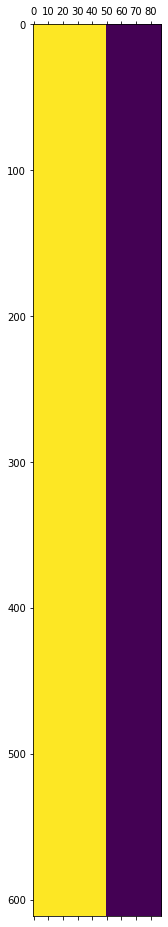

In [11]:
plt.matshow(attention[0][0][0].detach().cpu().numpy())